In [1]:
import itertools

import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.animation as animation
import numpy as np

import torch.nn.functional as F


# Load dataset

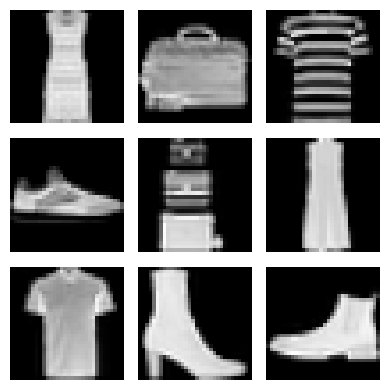

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 100
TIMESTEPS = 1000

DATASET = torchvision.datasets.FashionMNIST
SPLIT_BY_STR = False
CHANNELS = 1


def get_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),  # Scale back from [-1,1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        if image.shape[1] == 1:
            image = torch.cat([image, image, image], dim=1)
        image = image[0, :, :, :]
        # Convert grayscale to RGB
    elif image.shape[0] == 1:
        # Convert grayscale to RGB
        image = torch.cat([image, image, image], dim=0)
    return reverse_transforms(image)


def show_tensor_images(images, rows=1, cols=1, figsize=(4, 4)):
    _, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    if rows != 1 or cols != 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    for img, ax in zip(images, axs):
        ax.imshow(get_tensor_image(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    if SPLIT_BY_STR:
        train = DATASET(root=".", download=True, transform=data_transform, )
        test = DATASET(root=".", download=True, transform=data_transform, split='test')
    else:
        train = DATASET(root=".", download=True, transform=data_transform, train=True)
        test = DATASET(root=".", download=True, transform=data_transform, train=False)

    return ConcatDataset([train, test])


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

show_tensor_images([img for img, _ in itertools.islice(dataloader, 9)], 3, 3)


# Forward Process

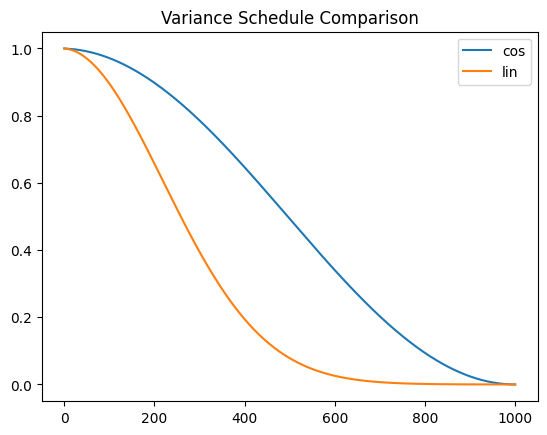

In [3]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alpha_bar = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alpha_bar = alpha_bar / alpha_bar[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


class ForwardValues():
    def __init__(self, timesteps):
        self.beta = cosine_beta_schedule(timesteps)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - self.alpha_bar)
        # For sampling
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alpha)
        self.alphas_cumprod_prev = F.pad(self.alpha_bar[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.beta * (1. - self.alphas_cumprod_prev) / (1. - self.alpha_bar)

    def batch_get(self, val, t: torch.Tensor, x_shape):
        batch_size = t.shape[0]
        out = val.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def sample_forward_process(values: ForwardValues, original_img, t, device="cpu"):
    original_img = original_img.to(device)
    noise = torch.randn_like(original_img)
    batched_alpha_bar = values.batch_get(values.sqrt_alpha_bar, t, original_img.shape)
    batched_sqrt_one_minus_alpha_bar = values.batch_get(values.sqrt_one_minus_alpha_bar, t, original_img.shape)

    mu = batched_alpha_bar * original_img
    sigma = batched_sqrt_one_minus_alpha_bar
    img_t = mu + sigma * noise
    return img_t, noise


plt.plot(torch.linspace(0, TIMESTEPS, TIMESTEPS), torch.cumprod(1-cosine_beta_schedule(timesteps=TIMESTEPS), axis=0), label="cos")
plt.plot(torch.linspace(0, TIMESTEPS, TIMESTEPS), torch.cumprod(1-linear_beta_schedule(timesteps=TIMESTEPS), axis=0), label="lin")
plt.title("Variance Schedule Comparison")
plt.legend()
plt.show()


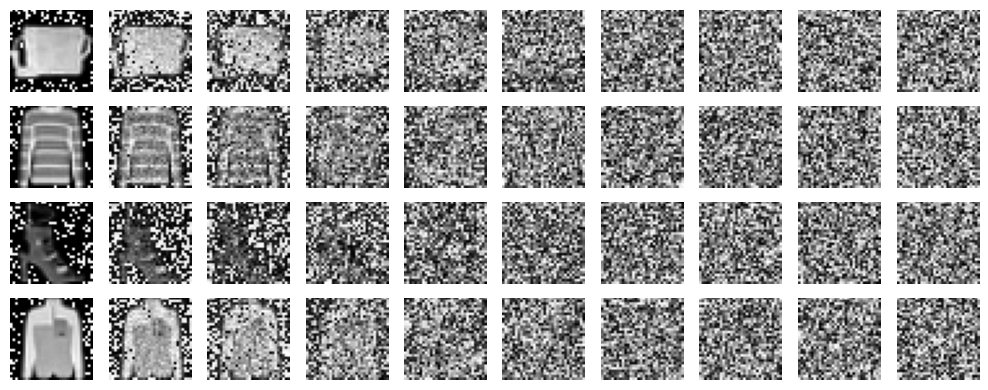

In [4]:
# Simulate forward diffusion

original_image = next(iter(dataloader))
values = ForwardValues(1000)

num_images = 10
stepsize = int(TIMESTEPS/num_images)

fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(10, 4))
axs = axs.flatten()
gif_images = []

for i in range(0, TIMESTEPS, stepsize):
    t = torch.Tensor([i]).type(torch.int64)
    image, noise = sample_forward_process(values, original_image[0], t, t.device)
    gif_images.append(image[:4])
for img, ax in zip([x for pair in zip(*gif_images) for x in pair], axs):
    ax.imshow(get_tensor_image(img))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Simple U-Net

In [5]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = CHANNELS
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], CHANNELS, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62437601


# Loss Function

In [6]:
def get_loss(model, vals, x_0, t, device, loss_type="l1"):
    x_noisy, noise = sample_forward_process(vals, x_0, t, device)
    predicted_noise = model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


In [7]:
@torch.no_grad()
def sample_timestep(vals: ForwardValues, x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    beta = vals.batch_get(vals.beta, t, x.shape)
    sqrt_one_minus_alpha_bar = vals.batch_get(vals.sqrt_one_minus_alpha_bar, t, x.shape)
    sqrt_recip_alpha = vals.batch_get(vals.sqrt_recip_alpha, t, x.shape)
    posterior_variance = vals.batch_get(vals.posterior_variance, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alpha * (x - beta * model(x, t) / sqrt_one_minus_alpha_bar)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance) * noise


def show_gif():
    fig = plt.figure()
    ims = []
    for i in range(timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.show()


@torch.no_grad()
def sample_plot_image(vals, device, timesteps, num_images=10):
    # Sample noise
    img = torch.randn((1, CHANNELS, IMG_SIZE, IMG_SIZE), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    stepsize = int(timesteps/num_images)

    for i in range(0, timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(vals, img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.axis('off')
            image = get_tensor_image(img.detach().cpu())
            plt.imshow(image)
    plt.show()


# Training

Using cuda


C:\Users\Bitwise\AppData\Local\Temp\ipykernel_17828\3971437547.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


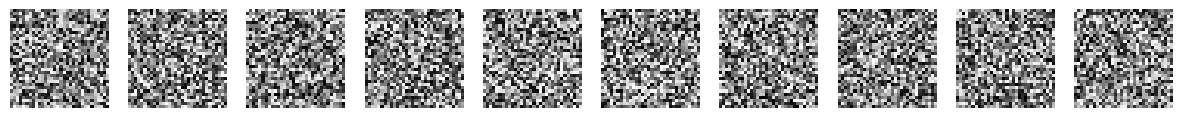

Epoch 0 | step 699 Loss: 0.13237087428569794 


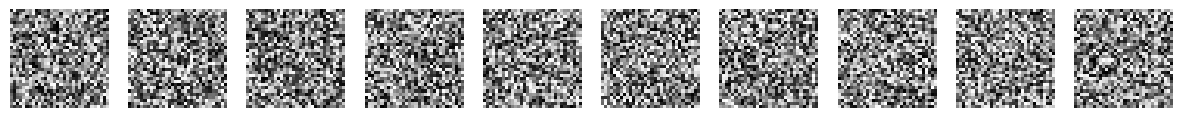

Epoch 1 | step 699 Loss: 0.1299566924571991 
Epoch 2 | step 699 Loss: 0.10839973390102386 
Epoch 3 | step 699 Loss: 0.11993507295846939 
Epoch 4 | step 699 Loss: 0.12265198677778244 
Epoch 5 | step 699 Loss: 0.112144336104393 


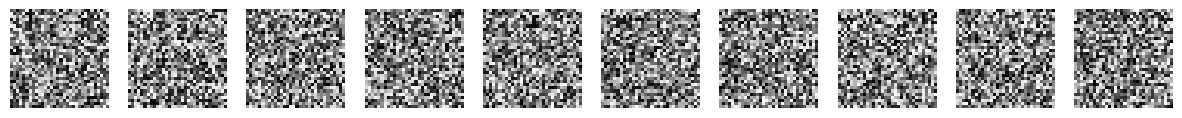

Epoch 6 | step 699 Loss: 0.11099734157323837 


In [8]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 200

sample_plot_image(values, device, TIMESTEPS)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, values, batch[0], t, device)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
    if epoch % 5 == 0:
        sample_plot_image(values, device, TIMESTEPS)
